# Lab 4: Pattern Recognition

## Setting up the environment and the dataset

In [26]:
import os
import numpy as np
import pandas as pd
import librosa
import seaborn as sns
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical
import IPython.display as ipd
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, TensorDataset


In [2]:
METADATA_PATH = "/kaggle/input/alexu-pr-2025-4/UrbanSound8K/metadata/UrbanSound8K.csv"
AUDIO_DIR = "/kaggle/input/alexu-pr-2025-4/UrbanSound8K/audio/"

df = pd.read_csv(METADATA_PATH)
print("Metadata shape:", df.shape)
df.head()

Metadata shape: (8732, 8)


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

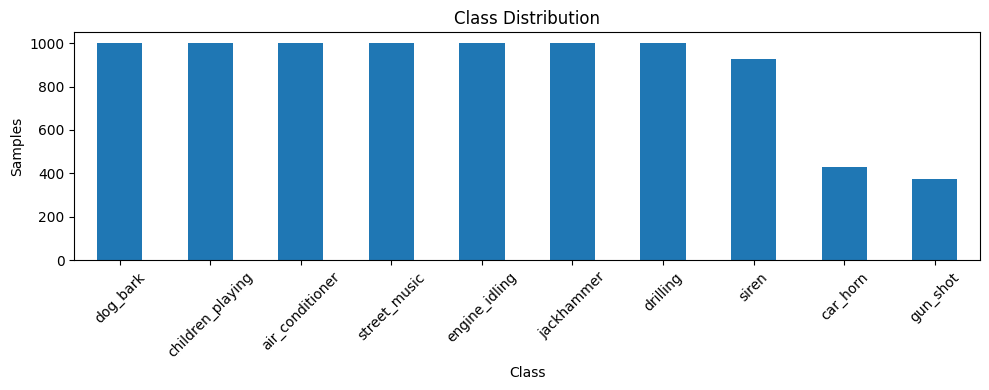

In [3]:
df['class'].value_counts().plot(kind='bar', title='Class Distribution', figsize=(10,4))
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Samples")
plt.tight_layout()
plt.show()


In [5]:
def load_audio(row):
    file_path = os.path.join(AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

def plot_waveform(y, sr, title="Waveform"):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def plot_spectrogram(y, sr, title="Mel Spectrogram"):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def play_audio(y, sr):
    return ipd.Audio(data=y, rate=sr)



Class: dog_bark


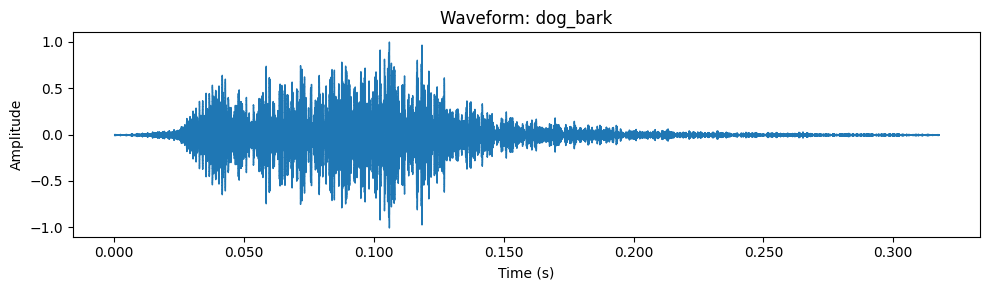

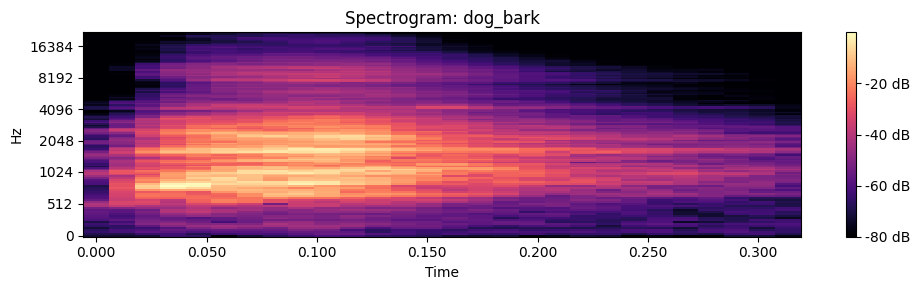


Class: children_playing


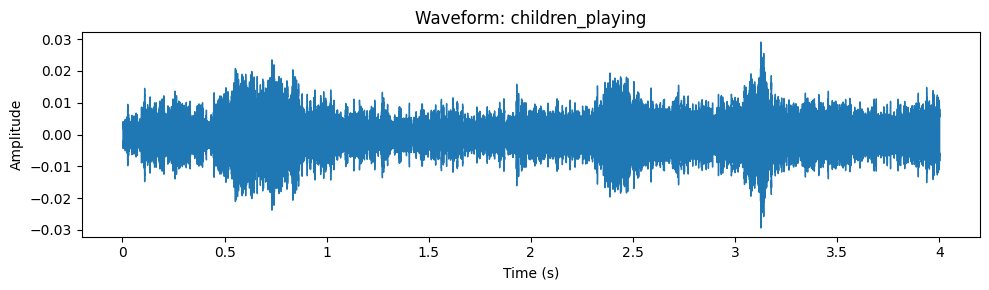

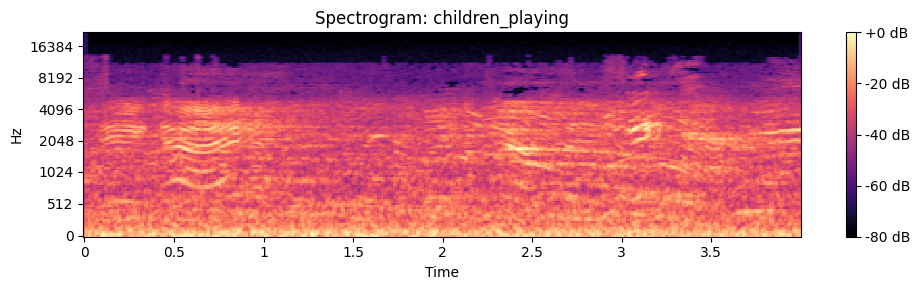


Class: car_horn


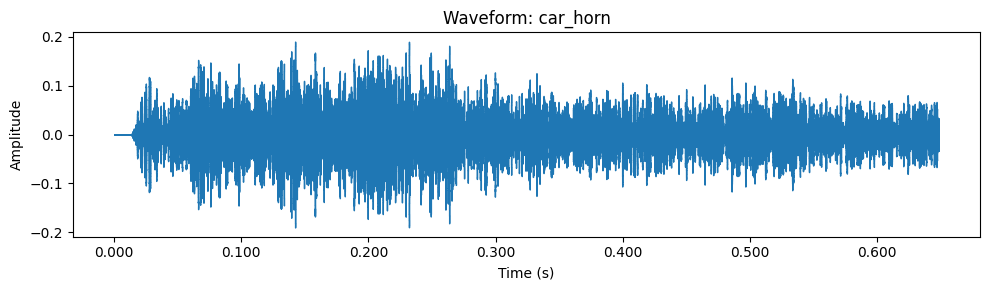

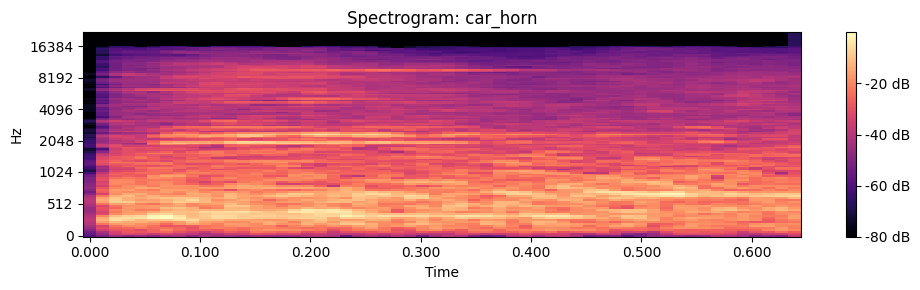


Class: air_conditioner


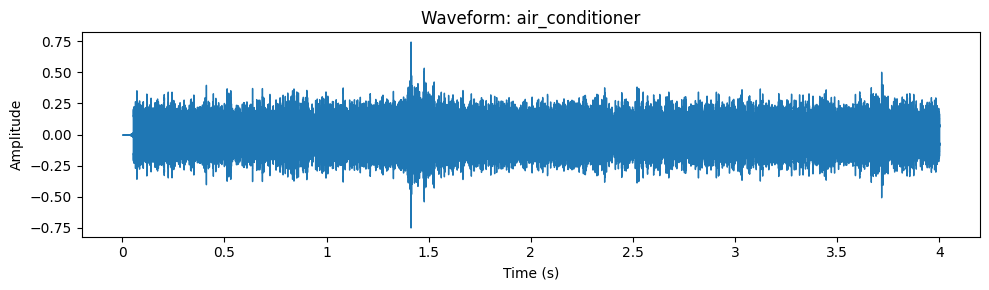

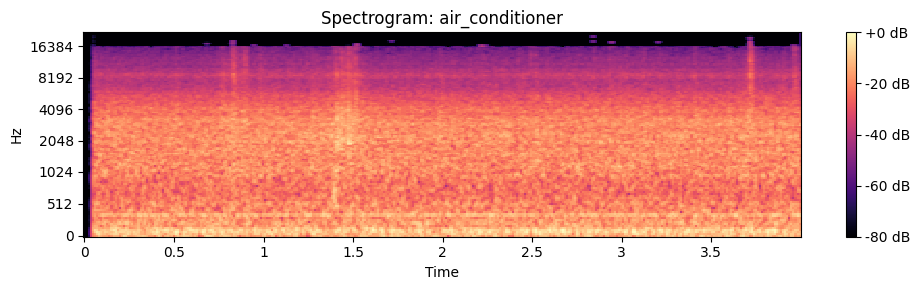


Class: street_music


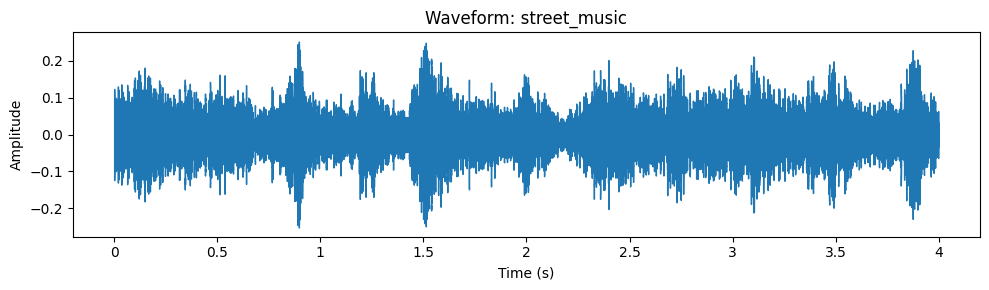

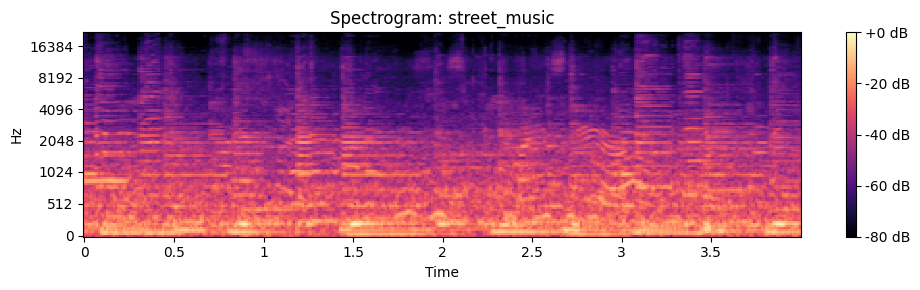


Class: gun_shot


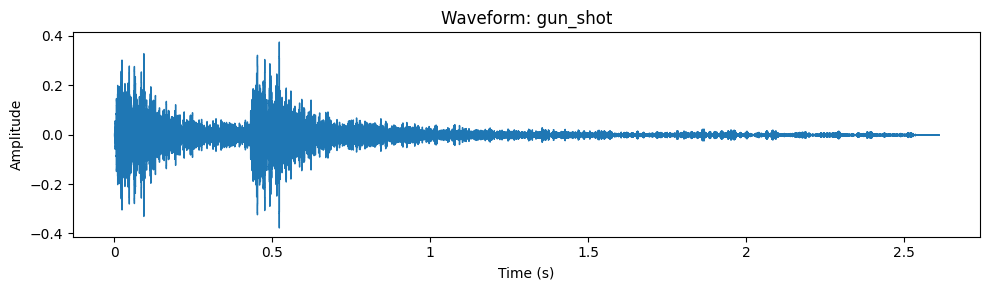

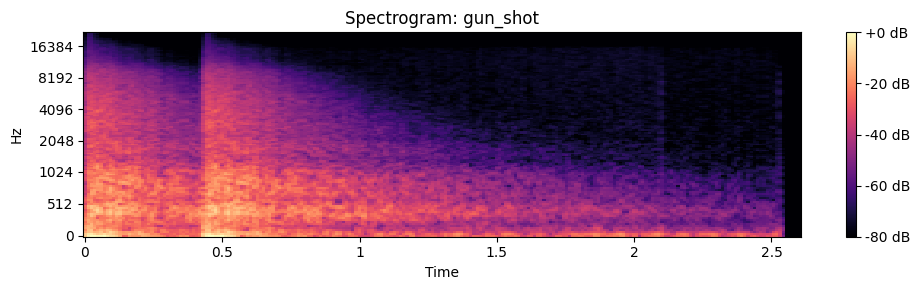


Class: siren


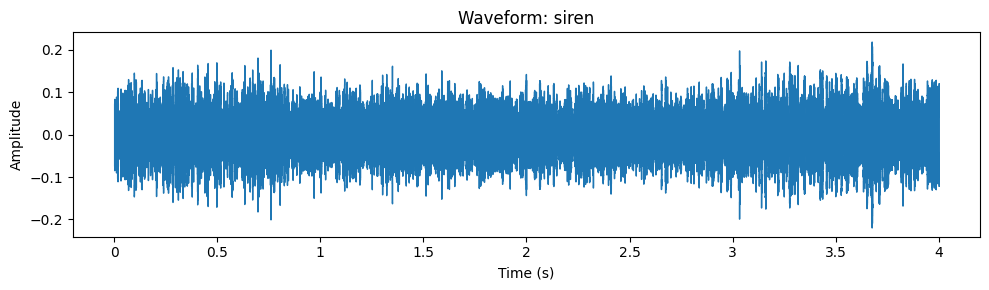

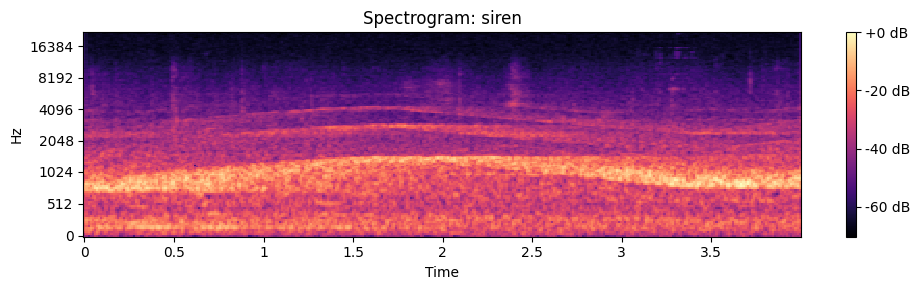


Class: engine_idling


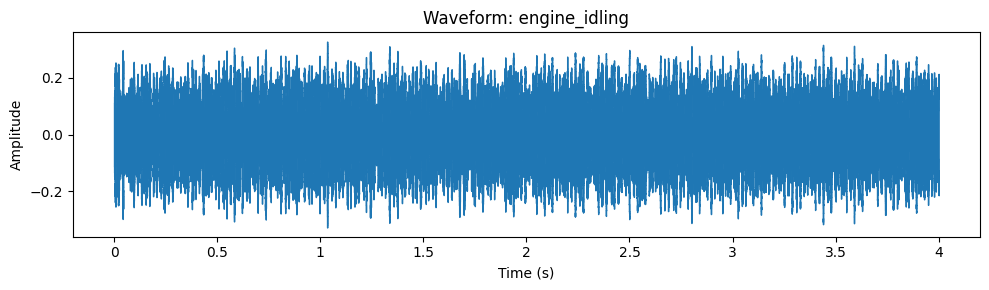

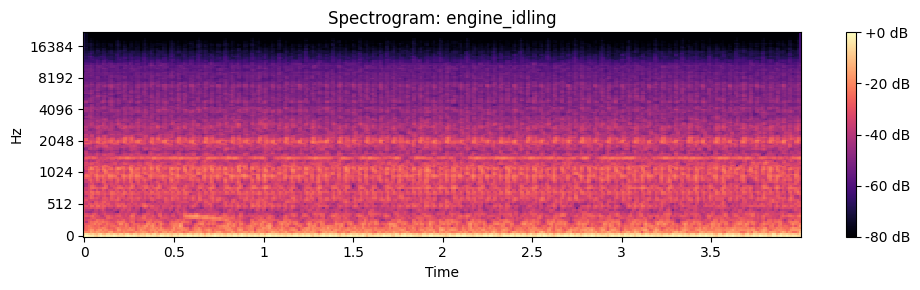


Class: jackhammer


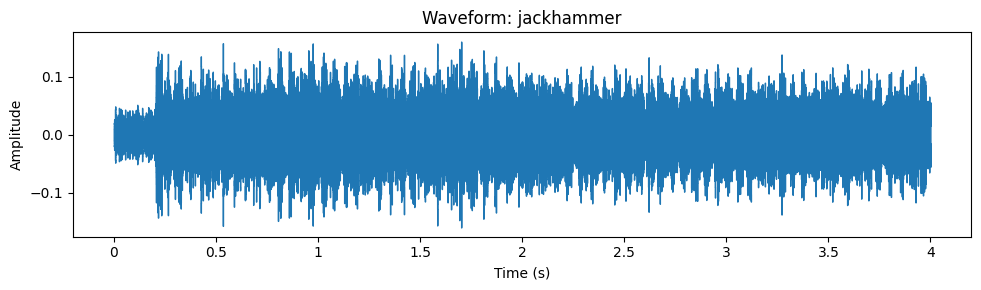

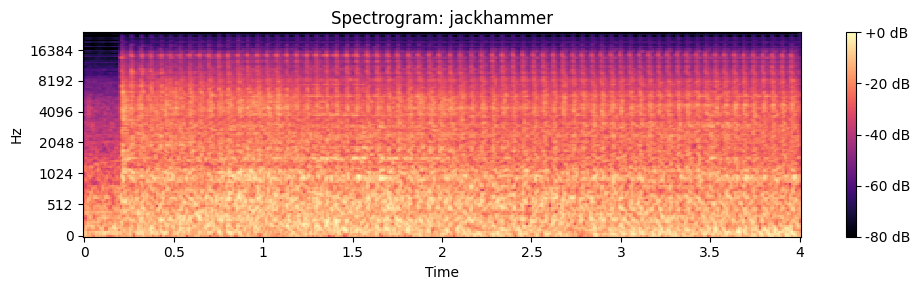


Class: drilling


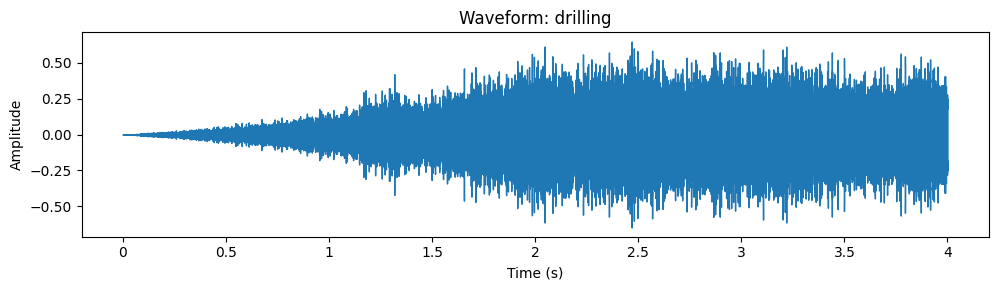

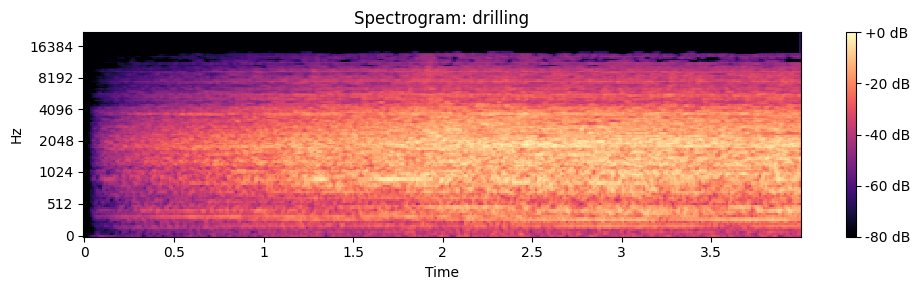

In [6]:
unique_classes = df['class'].unique()

for cls in unique_classes:
    row = df[df['class'] == cls].iloc[0]
    y, sr = load_audio(row)
    print(f"\nClass: {cls}")
    display(play_audio(y, sr))
    plot_waveform(y, sr, title=f"Waveform: {cls}")
    plot_spectrogram(y, sr, title=f"Spectrogram: {cls}")


In [7]:
train_df = df[df['fold'].isin([1, 2, 3, 4, 5, 6])]
val_df   = df[df['fold'].isin([7, 8])]
test_df  = df[df['fold'].isin([9, 10])]

In [8]:
def extract_melspectrogram(y, sr, n_mels=128):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    return librosa.power_to_db(S, ref=np.max)

def extract_energy(y):
    return librosa.feature.rms(y=y)[0]

def extract_mfccs(y, sr, n_mfcc=13):
    return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

def extract_features(row):
    file_path = os.path.join(AUDIO_DIR, f"fold{row['fold']}", row['slice_file_name'])
    y, sr = librosa.load(file_path, sr=None)

    mfccs = extract_mfccs(y, sr)
    energy = extract_energy(y)
    mel = extract_melspectrogram(y, sr)

    feature_dict = {
        'mfcc_mean': np.mean(mfccs, axis=1),
        'mfcc_std': np.std(mfccs, axis=1),
        'energy_mean': np.mean(energy),
        'energy_std': np.std(energy),
        'mel_mean': np.mean(mel, axis=1),
        'mel_std': np.std(mel, axis=1),
    }
    return feature_dict

In [9]:
def flatten_feature_dict(feature_dict):
    flat_features = []
    for key, value in feature_dict.items():
        if isinstance(value, np.ndarray):
            flat_features.extend(value.tolist())
        else:
            flat_features.append(value)
    return flat_features

def process_dataframe(df_subset):
    features = []
    labels = []
    for _, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
        try:
            feat_dict = extract_features(row)
            flat_feat = flatten_feature_dict(feat_dict)
            features.append(flat_feat)
            labels.append(row['class'])
        except Exception as e:
            print(f"Error processing file {row['slice_file_name']}: {e}")
    return np.array(features), np.array(labels)

In [10]:
X_train, y_train = process_dataframe(train_df)
X_val, y_val     = process_dataframe(val_df)
X_test, y_test   = process_dataframe(test_df)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)

 33%|███▎      | 538/1644 [00:31<00:54, 20.14it/s]/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████| 1653/1653 [01:39<00:00, 16.53it/s]


In [11]:
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)
timesteps = 13  
features_per_step = X_train.shape[1] // timesteps

def reshape_for_rnn(X):
    return X[:, :timesteps*features_per_step].reshape((-1, timesteps, features_per_step))

In [13]:
X_train_rnn = reshape_for_rnn(X_train)
X_val_rnn   = reshape_for_rnn(X_val)
X_test_rnn  = reshape_for_rnn(X_test)

## Part 1: RNN

In [16]:
learning_rates = [0.001, 0.0001, 0.00001] 
epochs_list = [50, 100, 200]                 

best_val_accuracy = 0
best_lr = None
best_epochs = None
best_model = None

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"\n=== Training with lr={lr}, epochs={epochs} ===")
        
        model = Sequential([
            Masking(mask_value=0., input_shape=(timesteps, features_per_step)),
            SimpleRNN(64, activation='tanh', return_sequences=False),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        
       
        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=lr),  
            metrics=['accuracy']
        )
        
       
        history = model.fit(
            X_train_rnn, y_train_cat,
            validation_data=(X_val_rnn, y_val_cat),
            epochs=epochs,
            batch_size=32,
        )
        
       
        val_accuracy = max(history.history['val_accuracy'])
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
       
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_lr = lr
            best_epochs = epochs
            best_model = model
           

print("\n Best Hyperparameters")
print(f"Learning Rate: {best_lr}")
print(f"Epochs: {best_epochs}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")





=== Training with lr=0.001, epochs=50 ===
Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1710 - loss: 2.2972 - val_accuracy: 0.2530 - val_loss: 1.9747
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2912 - loss: 1.9248 - val_accuracy: 0.3437 - val_loss: 1.8466
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3447 - loss: 1.8139 - val_accuracy: 0.3869 - val_loss: 1.7806
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3749 - loss: 1.7056 - val_accuracy: 0.3613 - val_loss: 1.7753
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4183 - loss: 1.6229 - val_accuracy: 0.3790 - val_loss: 1.7700
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4402 - loss: 1.5541 - val_accuracy: 0.3534 - val_loss: 1.7563
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4542 - loss: 1.5106 - val_accuracy: 0.3990 - val_loss: 1.7274
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accurac

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5432 - loss: 1.6776
Test Accuracy: 0.5027
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
F1 Score (weighted): 0.4966


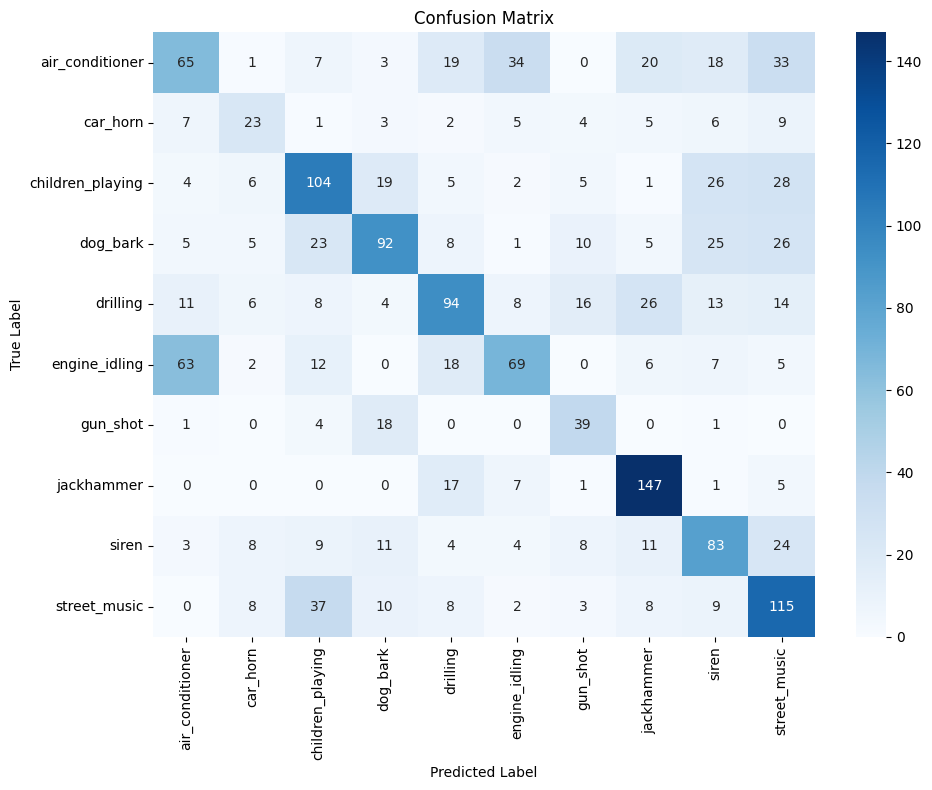

In [19]:
test_loss, test_acc = best_model.evaluate(X_test_rnn, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")
y_pred_probs = best_model.predict(X_test_rnn)  
y_pred_classes = np.argmax(y_pred_probs, axis=1) 
f1 = f1_score(y_test_enc, y_pred_classes, average='weighted') 
print(f"F1 Score (weighted): {f1:.4f}")

cm = confusion_matrix(y_test_enc, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Part 2: Transformers

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0)) 

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        qkv = self.qkv(x).view(B, T, 3, self.num_heads, self.d_k).permute(2, 0, 3, 1, 4)
        Q, K, V = qkv[0], qkv[1], qkv[2]
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)
        attn = torch.softmax(scores, dim=-1)
        context = attn @ V
        context = context.transpose(1, 2).reshape(B, T, D)
        return self.out(context)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x):
        return self.net(x)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = PositionwiseFeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, d_ff, num_layers, num_classes, max_len=500):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.encoders = nn.Sequential(*[
            TransformerEncoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)           
        x = self.pos_enc(x)
        x = self.encoders(x)             
        x = x.mean(dim=1)               
        return self.classifier(x)


In [29]:
from sklearn.metrics import accuracy_score
import torch.optim as optim

X_train_tensor = torch.tensor(X_train_rnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_rnn, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_enc, dtype=torch.long)

batch_size = 64
d_model = 128
num_heads = 4
num_layers = 2

learning_rates = [0.001, 0.0001]  
epochs_list = [50, 100]            

best_acc = 0
best_lr = None
best_epochs = None
best_model = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"\nTraining: lr={lr}, epochs={epochs}")
        
        model = TransformerClassifier(
            input_dim=X_train_rnn.shape[-1],
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_model * 4,
            num_layers=num_layers,
            num_classes=len(torch.unique(y_train_tensor))
        ).to(device)
        
        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(X_val_tensor, y_val_tensor),
            batch_size=batch_size
        )
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            
            model.eval()
            all_preds = []
            with torch.no_grad():
                for xb, _ in val_loader:
                    preds = model(xb.to(device))
                    all_preds.append(preds.argmax(1).cpu())
            
            val_acc = accuracy_score(y_val_tensor, torch.cat(all_preds))
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_lr = lr
            best_epochs = epochs
            best_model = model.state_dict()

print(f"\nBest lr: {best_lr}, Best epochs: {best_epochs}")
print(f"Best Val Accuracy: {best_acc:.4f}")



Training: lr=0.001, epochs=50
Epoch 1/50 - Loss: 1.8255 - Val Acc: 0.3929
Epoch 2/50 - Loss: 1.3763 - Val Acc: 0.5116
Epoch 3/50 - Loss: 1.1360 - Val Acc: 0.5189
Epoch 4/50 - Loss: 0.9779 - Val Acc: 0.5438
Epoch 5/50 - Loss: 0.8858 - Val Acc: 0.5773
Epoch 6/50 - Loss: 0.7619 - Val Acc: 0.5657
Epoch 7/50 - Loss: 0.7405 - Val Acc: 0.5432
Epoch 8/50 - Loss: 0.6694 - Val Acc: 0.5651
Epoch 9/50 - Loss: 0.5699 - Val Acc: 0.5523
Epoch 10/50 - Loss: 0.5500 - Val Acc: 0.5894
Epoch 11/50 - Loss: 0.4429 - Val Acc: 0.5803
Epoch 12/50 - Loss: 0.4004 - Val Acc: 0.5766
Epoch 13/50 - Loss: 0.4090 - Val Acc: 0.5298
Epoch 14/50 - Loss: 0.3651 - Val Acc: 0.5335
Epoch 15/50 - Loss: 0.3408 - Val Acc: 0.5657
Epoch 16/50 - Loss: 0.3325 - Val Acc: 0.5359
Epoch 17/50 - Loss: 0.3368 - Val Acc: 0.5499
Epoch 18/50 - Loss: 0.2657 - Val Acc: 0.5596
Epoch 19/50 - Loss: 0.2506 - Val Acc: 0.5724
Epoch 20/50 - Loss: 0.1708 - Val Acc: 0.5529
Epoch 21/50 - Loss: 0.2755 - Val Acc: 0.5578
Epoch 22/50 - Loss: 0.2369 - Val 

Test Accuracy: 0.5910
Test F1 Score: 0.5855


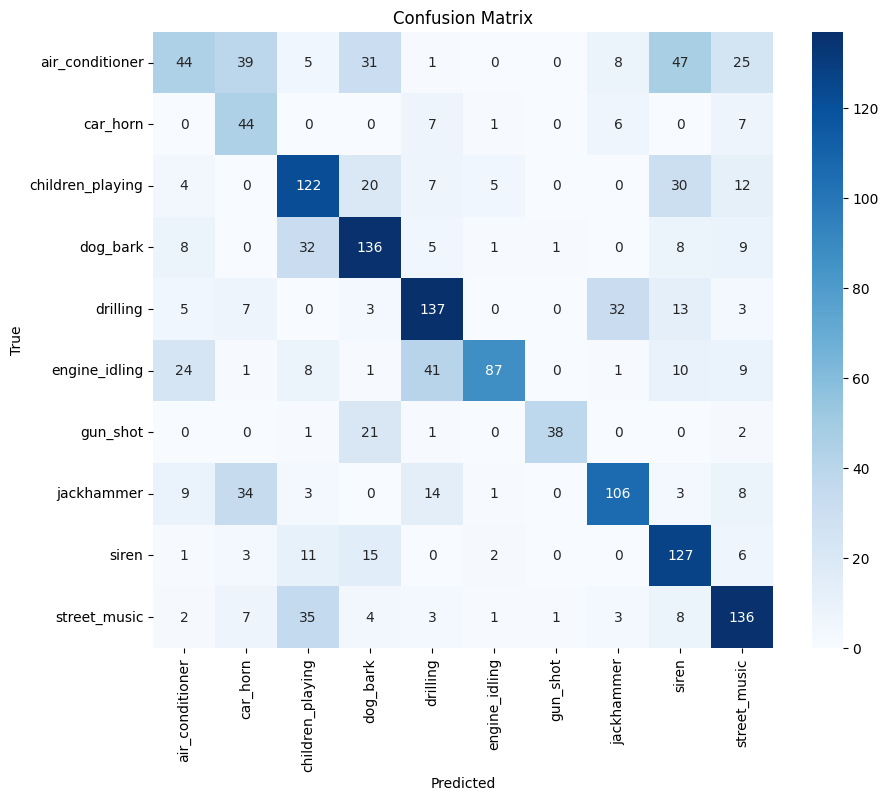

In [31]:
X_test_tensor = torch.tensor(X_test_rnn, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)  # Ensure this is class indices (not one-hot)

test_model = TransformerClassifier(
    input_dim=X_train_rnn.shape[-1],
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_model*4,
    num_layers=num_layers,
    num_classes=len(torch.unique(y_train_tensor))
).to(device)

test_model.load_state_dict(best_model)  
test_model.eval()  

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),
                        batch_size=batch_size)

all_preds = []
all_true = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        outputs = test_model(xb)
        all_preds.append(outputs.argmax(1).cpu())
        all_true.append(yb)

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_true).numpy()

test_acc = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Bonus Part

In [36]:
import torch
import torch.nn as nn

class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_height, input_width, num_classes=10):
        super(CNNLSTMClassifier, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                        
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                        
        )
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_height, input_width)
            dummy_output = self.cnn(dummy_input)
            self.lstm_input_dim = dummy_output.size(1) * dummy_output.size(2)  
            self.sequence_length = dummy_output.size(3)  
        
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_dim,
            hidden_size=128,
            batch_first=True
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
    
        x = self.cnn(x)  
        
        x = x.permute(0, 3, 1, 2)  
        x = x.reshape(x.size(0), x.size(1), -1)  
        
        lstm_out, _ = self.lstm(x)  

        last_out = lstm_out[:, -1, :]  
        
        return self.classifier(last_out) 

In [38]:

X_train_4d = X_train_rnn.reshape(X_train_rnn.shape[0], 1, X_train_rnn.shape[1], X_train_rnn.shape[2])  # [B, C, H, W]
X_val_4d = X_val_rnn.reshape(X_val_rnn.shape[0], 1, X_val_rnn.shape[1], X_val_rnn.shape[2])
X_test_4d = X_test_rnn.reshape(X_test_rnn.shape[0], 1, X_test_rnn.shape[1], X_test_rnn.shape[2])

X_train_tensor = torch.tensor(X_train_4d, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_4d, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_4d, dtype=torch.float32)
batch_size = 64
learning_rates = [0.001, 0.0001]
epochs_list = [50, 100, 200]

best_acc = 0
best_lr = None
best_epochs = None
best_model = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    for epochs in epochs_list:
        print(f"\nTraining: lr={lr}, epochs={epochs}")
        
        # Initialize model with input dimensions
        model = CNNLSTMClassifier(
        input_height=X_train_4d.shape[2],
        input_width=X_train_4d.shape[3],
        num_classes=len(torch.unique(y_train_tensor)))
        model = model.to(device)
        
        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(X_val_tensor, y_val_tensor),
            batch_size=batch_size
        )
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            
            model.eval()
            all_preds = []
            with torch.no_grad():
                for xb, _ in val_loader:
                    preds = model(xb.to(device))
                    all_preds.append(preds.argmax(1).cpu())
            
            val_acc = accuracy_score(y_val_tensor, torch.cat(all_preds))
            print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_lr = lr
            best_epochs = epochs
            best_model = model

print(f"\nBest lr: {best_lr}, Best epochs: {best_epochs}")
print(f"Best Val Accuracy: {best_acc:.4f}")


Training: lr=0.001, epochs=50
Epoch 1/50 - Loss: 2.0992 - Val Acc: 0.2755
Epoch 2/50 - Loss: 1.8211 - Val Acc: 0.3698
Epoch 3/50 - Loss: 1.5807 - Val Acc: 0.3984
Epoch 4/50 - Loss: 1.4080 - Val Acc: 0.4325
Epoch 5/50 - Loss: 1.2393 - Val Acc: 0.4927
Epoch 6/50 - Loss: 1.1199 - Val Acc: 0.5815
Epoch 7/50 - Loss: 0.9662 - Val Acc: 0.5700
Epoch 8/50 - Loss: 0.8762 - Val Acc: 0.5627
Epoch 9/50 - Loss: 0.8356 - Val Acc: 0.5779
Epoch 10/50 - Loss: 0.7308 - Val Acc: 0.6137
Epoch 11/50 - Loss: 0.6373 - Val Acc: 0.5943
Epoch 12/50 - Loss: 0.5825 - Val Acc: 0.5742
Epoch 13/50 - Loss: 0.5344 - Val Acc: 0.5943
Epoch 14/50 - Loss: 0.4931 - Val Acc: 0.6156
Epoch 15/50 - Loss: 0.4565 - Val Acc: 0.6296
Epoch 16/50 - Loss: 0.3991 - Val Acc: 0.6204
Epoch 17/50 - Loss: 0.3773 - Val Acc: 0.6150
Epoch 18/50 - Loss: 0.3331 - Val Acc: 0.6204
Epoch 19/50 - Loss: 0.3353 - Val Acc: 0.6058
Epoch 20/50 - Loss: 0.3211 - Val Acc: 0.6186
Epoch 21/50 - Loss: 0.2733 - Val Acc: 0.5967
Epoch 22/50 - Loss: 0.2464 - Val 


Test Accuracy: 0.6576
Test F1 Score: 0.6510


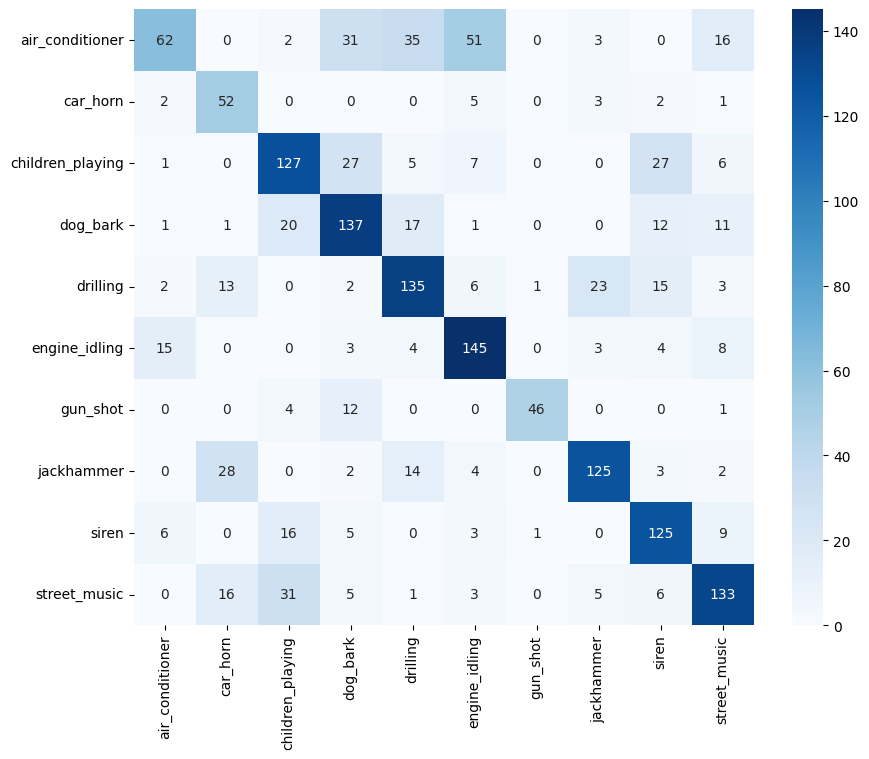

In [39]:
X_test_tensor = torch.tensor(
    X_test_rnn.reshape(X_test_rnn.shape[0], 1, X_test_rnn.shape[1], X_test_rnn.shape[2]), 
    dtype=torch.float32
).to(device)

with torch.no_grad():
    outputs = best_model(X_test_tensor)  
    y_pred = outputs.argmax(1).cpu().numpy()
    y_probs = torch.softmax(outputs, dim=1).cpu().numpy()

test_acc = accuracy_score(y_test_enc, y_pred)
test_f1 = f1_score(y_test_enc, y_pred, average='weighted')
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test_enc, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.show()